# [W&B] American Sign Language Detection

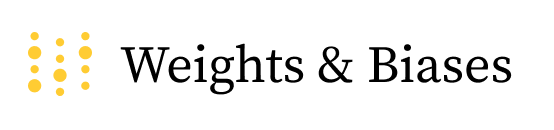

## Introduction

Hello and welcome all to my first Kaggle notebook in a few years. Generally I write blog posts - the most recent ones being on [CLIP](https://amaarora.github.io/posts/2023-03-11_Understanding_CLIP_part_2.html), but have recently taken an interest into Kaggle. The idea is to create clear concise high scoring notebooks to share with all.

I started competing in this competition about 2 weeks ago and have spent few hours every day for the past few weeks experimenting on this competition. I hadn't used Tensorflow or Keras before this competition - so want to take my time to thank all the Kagglers who have openly shared their solutions. Since, I learnt from you all, I am sharing my solution too. 

As part of this notebook I will also share my learnings based on the experiments so far and also possible ideas that could potentially make the solution even better. 

> At the time of writing, this notebook has the highest score on public leaderboard and ranks $48/709$. 

If you'd like to team up and work in the ideas that I have shared in this notebook, feel free to reach out to me. :) 

## Credits

1. Thank you @markwijkhuizen for your highest scoring single Transformer model [notebook [LB 0.67]](https://www.kaggle.com/code/markwijkhuizen/gislr-tf-data-processing-transformer-training). 
2. Thank you @roberthatch for sharing [how to create features](https://www.kaggle.com/code/roberthatch/gislr-lb-0-63-on-the-shoulders) that have time information in them. IMHO, you have uplifted this competition as many other high scoring notebooks have been based on your feature set after. I myself tried over 60 different experiments on top of the notebook that you shared. 

## Experiment Tracking using Weights and Biases

I used [Weights and Biases](https://wandb.ai/) for experiment tracking. I ran a total of **83 different experiments** which I tracked using W&B. As part of this notebook I will also share my learnings from those experiments. 

Weights & Biases is the machine learning platform for developers to build better models faster. Use W&B's lightweight, interoperable tools to quickly track experiments, version and iterate on datasets, evaluate model performance, reproduce models, visualize results and spot regressions, and share findings with colleagues.

> For a quickstart on W&B, refer **[HERE](http://wandb.me/aman)**!

![img](https://raw.githubusercontent.com/amaarora/amaarora.github.io/master/images/kaggle_nb_01.png)

To access all my experiments - refer [here](https://wandb.ai/amanarora/asl-sings?workspace=user-amanarora).

As part of these experiments I tried a wide range of learning rates, model architectures, dataset features. I hope that the information I share here will be helpful to you in creating a winning solution.  

Now, with credits and introductions out of the way, let's get started.

## Imports

To be able to use trained model weights, please create a wandb API key and paste below:

In [1]:
import os, json, random, math, scipy, wandb
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedGroupKFold 
from types import SimpleNamespace
from pathlib import Path

## Utils

It is important to be able to test the models, since as part of this competition we only submit a `submission.zip` file that contains `model.tflite`, it is important to check that the model is working before submitting to the competition. 

In [2]:
# Source: https://www.kaggle.com/competitions/asl-signs/overview/evaluation
ROWS_PER_FRAME = 543

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

The above code from the evaluation page showcases how the test data is loaded in the competition. So if it works on our model, we can be rest assured that our submission won't fail (unless it times out..)

# Model-1 Transformer

First, we get started with the transformer model from the amazing [GISLR TF Data Processing & Transformer Training](https://www.kaggle.com/code/markwijkhuizen/gislr-tf-data-processing-transformer-training) notebook by [Mark Wijkhuizen](https://www.kaggle.com/markwijkhuizen). 

The only difference between our version and the original version is that we trained the model on the whole dataset instead of just the training dataset as in the original notebook. *The single model trained on complete dataset is able to achieve a score of 0.68 on the public leaderboard.*

## Config and setup

In [3]:
# SimpleNamespace()はオブジェクトと違って、attributeを追加削除できる
cfg = SimpleNamespace()

In [4]:
# kaggleの環境で走っている確認
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [5]:
DATA_DIR         = Path('../data/') if not iskaggle else Path('/kaggle/input/asl-signs/')
TRAIN_CSV_PATH   = DATA_DIR/'train.csv'
LANDMARK_DIR     = DATA_DIR/'train_landmark_files'
LABEL_MAP_PATH   = DATA_DIR/'sign_to_prediction_index_map.json'

In [6]:
cfg.PREPROCESS_DATA = False
cfg.TRAIN_MODEL = False
cfg.N_ROWS = 543
cfg.N_DIMS = 3
cfg.DIM_NAMES = ['x', 'y', 'z']
cfg.SEED = 42
cfg.NUM_CLASSES = 250
cfg.IS_INTERACTIVE = True
cfg.VERBOSE = 2
cfg.INPUT_SIZE = 32
cfg.BATCH_ALL_SIGNS_N = 4
cfg.BATCH_SIZE = 256
cfg.N_EPOCHS = 50
cfg.LR_MAX = 1e-3
cfg.N_WARMUP_EPOCHS = 0
cfg.WD_RATIO = 0.05
cfg.MASK_VAL = 4237

In [7]:
# Read Training Data
train = pd.read_csv(TRAIN_CSV_PATH)
N_SAMPLES = len(train)
N_SAMPLES

94477

Below, instead of updating the path on the train file, we create a symlink instead. 

In [8]:
# Get complete file path to file
def get_file_path(path):
    return f'/kaggle/input/asl-signs/{path}'

!ln -s {LANDMARK_DIR} ./train_landmark_files
train['file_path'] = train['path'].values  # pathカラムと同じカラムをfile_pathカラムに作る
train.head()

,path,participant_id,sequence_id,sign,file_path
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,train_landmark_files/26734/1000035562.parquet
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,train_landmark_files/28656/1000106739.parquet
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,train_landmark_files/16069/100015657.parquet
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,train_landmark_files/25571/1000210073.parquet
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,train_landmark_files/62590/1000240708.parquet


Next, as in the original notebook, we convert the sign to a category and convert sign to codes and assign it as `sign_org`. 

In [9]:
train['sign_ord'] = train['sign'].astype('category').cat.codes
SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

I am not sure why the author did this, could have also used the mapping provided to us in the competition. 

## Kfold

Below, we create K-folds using `StratifiedGroupKFold`, the idea  is to have different participants in train and validation. This mimics the test scenario better compared to a random train-test-split IMHO. 

In [10]:
from sklearn.model_selection import StratifiedGroupKFold

In [11]:
train.participant_id.nunique()

21

In [12]:
N_PARTICIPANTS = train.participant_id.nunique()
sgkf = StratifiedGroupKFold(n_splits=7, shuffle=True, random_state=42)
train['fold'] = -1
# .splitでfoldごとのインデックスリストが帰ってくる .split(X, y, groups) -> participantごとにfoldする
for i, (train_idx, val_idx) in enumerate(sgkf.split(train.index, train.sign, train.participant_id)):
    train.loc[val_idx, 'fold'] = i  # trainの各行にfoldの数を入れる
train.head()

,path,participant_id,sequence_id,sign,file_path,sign_ord,fold
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,train_landmark_files/26734/1000035562.parquet,25,3
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,train_landmark_files/28656/1000106739.parquet,232,0
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,train_landmark_files/16069/100015657.parquet,48,3
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,train_landmark_files/25571/1000210073.parquet,23,1
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,train_landmark_files/62590/1000240708.parquet,164,5


In [13]:
# create indexes using fold `0` for now
# foldが0以外がtrainデータ、flodが0がvalデータ
train_idxs = train.query("fold!=0").index.values
val_idxs = train.query("fold==0").index.values

In [14]:
len(train_idxs), len(val_idxs)

(80610, 13867)

## Process Data Tensorflow

Next, we copy the `PreprocessLayer` as from the original notebook - https://www.kaggle.com/code/roberthatch/gislr-lb-0-63-on-the-shoulders with some pre-defined variables. 

> One thing I noted, the pose indices - they have values `np.arange(502, 512)`, is this right? Shouldn't this be `np.arange(489,522)`? Something for you to experiment. :) 

In [15]:
# landmark indices in original data
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])
LEFT_HAND_IDXS0  = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
POSE_IDXS0       = np.arange(502, 512)
LANDMARK_IDXS0   = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0, POSE_IDXS0))
HAND_IDXS0       = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
N_COLS           = LANDMARK_IDXS0.size
N_COLS, LANDMARK_IDXS0

(92,
 array([ 61, 185,  40,  39,  37,   0, 267, 269, 270, 409, 291, 146,  91,
        181,  84,  17, 314, 405, 321, 375,  78, 191,  80,  81,  82,  13,
        312, 311, 310, 415,  95,  88, 178,  87,  14, 317, 402, 318, 324,
        308, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479,
        480, 481, 482, 483, 484, 485, 486, 487, 488, 522, 523, 524, 525,
        526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538,
        539, 540, 541, 542, 502, 503, 504, 505, 506, 507, 508, 509, 510,
        511]))

In [16]:
# Landmark indices in processed data
# np.isin(array1, array2) -> array1の要素がarray2の要素の中にあったらそこはTrueになる、それ以外はFalse
# np.argwhere(array) 値が0以外の要素のインデックスの組を返す (Trueのインデックスを返す)
# 各インデックスが入っている
LIPS_IDXS       = np.argwhere(np.isin(LANDMARK_IDXS0, LIPS_IDXS0)).squeeze() 
LEFT_HAND_IDXS  = np.argwhere(np.isin(LANDMARK_IDXS0, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS0, RIGHT_HAND_IDXS0)).squeeze()
HAND_IDXS       = np.argwhere(np.isin(LANDMARK_IDXS0, HAND_IDXS0)).squeeze()
POSE_IDXS       = np.argwhere(np.isin(LANDMARK_IDXS0, POSE_IDXS0)).squeeze()

In [17]:
LIPS_IDXS

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

In the function below, if I am to explain it in my own words: 

We pad the input video data (out from `load_relevant_data_subset`) to `cfg.INPUT_SIZE #32` frames if number of frames is lower than `cfg.INPUT_SIZE`.

In [18]:
tf.repeat([4], repeats=3)

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([4, 4, 4], dtype=int32)>

In [19]:
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        
    def pad_edge(self, t, repeats, side):
        if side == 'LEFT':
            return tf.concat((tf.repeat(t[:1], repeats=repeats, axis=0), t), axis=0)
        elif side == 'RIGHT':
            return tf.concat((t, tf.repeat(t[-1:], repeats=repeats, axis=0)), axis=0)
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,cfg.N_ROWS,cfg.N_DIMS], dtype=tf.float32),),
    )
    def call(self, data0):
        # Number of Frames in Video
        N_FRAMES0 = tf.shape(data0)[0]
        
        # Keep only non-empty frames in data
        # numpy.nanmean()でNaNを無視した平均値を返す
        # tf.gather(params, indices) -> indicesに応じて、paramsから値を取り出してくる
        # handのデータの平均値
        frames_hands_nansum = tf.experimental.numpy.nanmean(tf.gather(data0, HAND_IDXS0, axis=1), axis=[1,2])
        # tf.where(condition) -> conditionがTrueの要素のインデックスを返す
        # 平均値が0より大きいデータ(空でないデータ）のインデックス 
        non_empty_frames_idxs = tf.where(frames_hands_nansum > 0)
        non_empty_frames_idxs = tf.squeeze(non_empty_frames_idxs, axis=1)
        # 空でないデータだけ取り出す
        data = tf.gather(data0, non_empty_frames_idxs, axis=0)
        
        non_empty_frames_idxs = tf.cast(non_empty_frames_idxs, tf.float32) 
        
        # Number of non-empty frames 空でないデータのフレーム数
        N_FRAMES = tf.shape(data)[0]
        # landmarkのインデックスに応じてそのデータだけを取り出す
        data = tf.gather(data, LANDMARK_IDXS0, axis=1)
        
        # 使えるフレーム数が、インプットサイズより小さい時
        if N_FRAMES < cfg.INPUT_SIZE:
            # Video fits in cfg.INPUT_SIZE
            # tf.pad()　でテンソルに対してパディングができる
            # inputsizeに満たしいない部分は-1でパディングする
            non_empty_frames_idxs = tf.pad(non_empty_frames_idxs, [[0, cfg.INPUT_SIZE-N_FRAMES]], constant_values=-1)
            # inputsizeに満たしいない部分は0でパディングする
            data = tf.pad(data, [[0, cfg.INPUT_SIZE-N_FRAMES], [0,0], [0,0]], constant_values=0)
            # tf.math.is_nan() nanの要素はTrueで帰ってくる　そうでない要素はFalse
            # nanの場合は0そうでない場合はそのままの値にする
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            return data, non_empty_frames_idxs
        else:# インプットサイズ以上の場合はサイズをおとす
            # Video needs to be downsampled to cfg.INPUT_SIZE
            # 2倍よりも小さいなら
            if N_FRAMES < cfg.INPUT_SIZE**2:
                # tf.math.floordiv(x, y) -> x / yを要素ごとにおこなう //と等しい
                # 何回繰り返せば良いか
                repeats = tf.math.floordiv(cfg.INPUT_SIZE * cfg.INPUT_SIZE, N_FRAMES0)
                # 繰り返し回数だけくりかしてデータを入れる
                data = tf.repeat(data, repeats=repeats, axis=0)
                non_empty_frames_idxs = tf.repeat(non_empty_frames_idxs, repeats=repeats, axis=0)

            # Pad To Multiple Of Input Size
            # 全データから何個パッチが作れるか pool_sizseはパッチの個数
            pool_size = tf.math.floordiv(len(data), cfg.INPUT_SIZE)
            # tf.math.mod(x, y) -> x/yの余りを返す
            # パッチを等しく分けれない時
            if tf.math.mod(len(data), cfg.INPUT_SIZE) > 0:
                # パッチのサイズを一個増やす
                pool_size += 1
            # パッチのサイズがたった1この時
            if pool_size == 1:
                pad_size = (pool_size * cfg.INPUT_SIZE) - len(data)
            else:
                # padサイズは最後のパッチのサイズ
                pad_size = (pool_size * cfg.INPUT_SIZE) % len(data)

            # Pad Start/End with Start/End value
            pad_left = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(cfg.INPUT_SIZE, 2)
            pad_right = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(cfg.INPUT_SIZE, 2)
            if tf.math.mod(pad_size, 2) > 0:
                pad_right += 1

            # Pad By Concatenating Left/Right Edge Values
            data = self.pad_edge(data, pad_left, 'LEFT')
            data = self.pad_edge(data, pad_right, 'RIGHT')

            # Pad Non Empty Frame Indices
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_left, 'LEFT')
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_right, 'RIGHT')

            # Reshape to Mean Pool
            data = tf.reshape(data, [cfg.INPUT_SIZE, -1, N_COLS, cfg.N_DIMS])
            non_empty_frames_idxs = tf.reshape(non_empty_frames_idxs, [cfg.INPUT_SIZE, -1])

            # Mean Pool
            data = tf.experimental.numpy.nanmean(data, axis=1)
            non_empty_frames_idxs = tf.experimental.numpy.nanmean(non_empty_frames_idxs, axis=1)

            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            
            return data, non_empty_frames_idxs
    
preprocess_layer = PreprocessLayer()

In [20]:
tf.math.mod(5, 1)

<tf.Tensor: shape=(), dtype=int32, numpy=0>

The best way to understand the function above is by calling it. Let's take below data as an example. So the input to the `preprocess_layer` is of shape $(23, 543, 3)$.

This represents 23 Frames, 543 landmarks (face, hand, pose) & 3 coordinates ($X$, $Y$ & $Z$).

In [21]:
# サンプルにparquetデータ一つからデータを取り出す
sample = load_relevant_data_subset(train.path[0])
sample.shape

(23, 543, 3)

In [22]:
# 取り出したサンプルデータに前処理をかける
data, non_empty_frames_idxs = preprocess_layer(sample)
data.shape, non_empty_frames_idxs

(TensorShape([32, 92, 3]),
 <tf.Tensor: shape=(32,), dtype=float32, numpy=
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 22., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.], dtype=float32)>)

In [23]:
# free up RAM, delete variables as we go
del data; del non_empty_frames_idxs

As can be seen above the output is of shape $(32, 92, 3)$, can you guess why? Take a minute to read the function above and try to guess why. It will help in your understanding of the code. :) 

In the output 32 represents the interpolated frame size, 92 key landmarks that we keep instead of 543 and 3 coordinates - $X$, $Y$ and $Z$.

What about when `N_FRAMES < cfg.INPUT_SIZE` is False? I leave that as an exercise for you. :) 

## Create Dataset

In [24]:
LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

In [25]:
def get_data(file_path):
    data = load_relevant_data_subset(file_path)
    data = preprocess_layer(data)
    return data

In [26]:
# サンプルではなく全てのデータに対して行う
def get_x_y():
    # Create arrays to save data
    X = np.zeros([N_SAMPLES, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y = np.zeros([N_SAMPLES], dtype=np.int32)
    NON_EMPTY_FRAME_IDXS = np.full([N_SAMPLES, INPUT_SIZE], -1, dtype=np.float32)

    for row_idx, (file_path, sign_ord) in enumerate(tqdm(train[['file_path', 'sign_ord']].values)):
        if row_idx % 5000 == 0:
            print(f'Generated {row_idx}/{N_SAMPLES}')

        data, non_empty_frame_idxs = get_data(file_path)
        X[row_idx] = data
        y[row_idx] = sign_ord
        NON_EMPTY_FRAME_IDXS[row_idx] = non_empty_frame_idxs
        if np.isnan(data).sum() > 0: return data

    # Save X/y
    np.save('X.npy', X)
    np.save('y.npy', y)
    np.save('NON_EMPTY_FRAME_IDXS.npy', NON_EMPTY_FRAME_IDXS)
    
    return X, y, NON_EMPTY_FRAME_IDXS

In [27]:
if cfg.PREPROCESS_DATA:
    X, y, NON_EMPTY_FRAME_IDXS = get_x_y()
else:
    X = np.load('/kaggle/input/gislr-dataset-public/X.npy')
    y = np.load('/kaggle/input/gislr-dataset-public/y.npy')
    NON_EMPTY_FRAME_IDXS = np.load('/kaggle/input/gislr-dataset-public/NON_EMPTY_FRAME_IDXS.npy')

In [28]:
X.shape, y.shape, NON_EMPTY_FRAME_IDXS.shape

((94477, 32, 92, 3), (94477,), (94477, 32))

## Feature Statistics - Lips

In [29]:
# LIPS
LIPS_MEAN_X  = np.zeros([LIPS_IDXS.size], dtype=np.float32)
LIPS_MEAN_Y  = np.zeros([LIPS_IDXS.size], dtype=np.float32)
LIPS_STD_X   = np.zeros([LIPS_IDXS.size], dtype=np.float32)
LIPS_STD_Y   = np.zeros([LIPS_IDXS.size], dtype=np.float32)

for col, ll in enumerate(tqdm( np.transpose(X[:,:,LIPS_IDXS], [2,3,0,1]).reshape([LIPS_IDXS.size, cfg.N_DIMS, -1]) )):
    for dim, l in enumerate(ll):
        v = l[np.nonzero(l)]
        if dim == 0: # X
            LIPS_MEAN_X[col] = v.mean()
            LIPS_STD_X[col] = v.std()
        if dim == 1: # Y
            LIPS_MEAN_Y[col] = v.mean()
            LIPS_STD_Y[col] = v.std()
        
LIPS_MEAN = np.array([LIPS_MEAN_X, LIPS_MEAN_Y]).T
LIPS_STD = np.array([LIPS_STD_X, LIPS_STD_Y]).T

  0%|          | 0/40 [00:00<?, ?it/s]

In [30]:
LIPS_MEAN

array([[0.41621253, 0.47286358],
       [0.41961774, 0.46850088],
       [0.4259194 , 0.46398672],
       [0.4352784 , 0.45886287],
       [0.45009747, 0.4540205 ],
       [0.46598187, 0.45563185],
       [0.48191077, 0.4531696 ],
       [0.49807605, 0.45723534],
       [0.50854623, 0.46182665],
       [0.51606447, 0.46596456],
       [0.5205674 , 0.47018802],
       [0.42088684, 0.47698584],
       [0.42751804, 0.48136103],
       [0.43815812, 0.48646846],
       [0.45204934, 0.4899064 ],
       [0.46841824, 0.4906653 ],
       [0.48489097, 0.48926488],
       [0.49900448, 0.48520103],
       [0.5095267 , 0.4795264 ],
       [0.5161358 , 0.47465026],
       [0.42128628, 0.47240794],
       [0.42840737, 0.4706431 ],
       [0.43501914, 0.46912196],
       [0.4436666 , 0.4678137 ],
       [0.45443463, 0.46722496],
       [0.4669518 , 0.46721676],
       [0.4797852 , 0.4665954 ],
       [0.49100533, 0.46661043],
       [0.50035226, 0.46742183],
       [0.50782615, 0.46858737],
       [0.

## Feature Statistics - Hands

In [31]:
# LEFT HAND
LEFT_HANDS_MEAN_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
LEFT_HANDS_MEAN_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
LEFT_HANDS_STD_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
LEFT_HANDS_STD_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
# RIGHT HAND
RIGHT_HANDS_MEAN_X = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)
RIGHT_HANDS_MEAN_Y = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)
RIGHT_HANDS_STD_X = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)
RIGHT_HANDS_STD_Y = np.zeros([RIGHT_HAND_IDXS.size], dtype=np.float32)

for col, ll in enumerate(tqdm( np.transpose(X[:,:,HAND_IDXS], [2,3,0,1]).reshape([HAND_IDXS.size, cfg.N_DIMS, -1]) )):
    for dim, l in enumerate(ll):
        v = l[np.nonzero(l)]
        if dim == 0: # X
            if col < RIGHT_HAND_IDXS.size: # LEFT HAND
                LEFT_HANDS_MEAN_X[col] = v.mean()
                LEFT_HANDS_STD_X[col] = v.std()
            else:
                RIGHT_HANDS_MEAN_X[col - LEFT_HAND_IDXS.size] = v.mean()
                RIGHT_HANDS_STD_X[col - LEFT_HAND_IDXS.size] = v.std()
        if dim == 1: # Y
            if col < RIGHT_HAND_IDXS.size: # LEFT HAND
                LEFT_HANDS_MEAN_Y[col] = v.mean()
                LEFT_HANDS_STD_Y[col] = v.std()
            else: # RIGHT HAND
                RIGHT_HANDS_MEAN_Y[col - LEFT_HAND_IDXS.size] = v.mean()
                RIGHT_HANDS_STD_Y[col - LEFT_HAND_IDXS.size] = v.std()
        
LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T
RIGHT_HANDS_MEAN = np.array([RIGHT_HANDS_MEAN_X, RIGHT_HANDS_MEAN_Y]).T
RIGHT_HANDS_STD = np.array([RIGHT_HANDS_STD_X, RIGHT_HANDS_STD_Y]).T

  0%|          | 0/42 [00:00<?, ?it/s]

## Feature Statistics - Pose

In [32]:
# POSE
POSE_MEAN_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
POSE_MEAN_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)
POSE_STD_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
POSE_STD_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)

for col, ll in enumerate(tqdm( np.transpose(X[:,:,POSE_IDXS], [2,3,0,1]).reshape([POSE_IDXS.size, cfg.N_DIMS, -1]) )):
    for dim, l in enumerate(ll):
        v = l[np.nonzero(l)]
        if dim == 0: # X
            POSE_MEAN_X[col] = v.mean()
            POSE_STD_X[col] = v.std()
        if dim == 1: # Y
            POSE_MEAN_Y[col] = v.mean()
            POSE_STD_Y[col] = v.std()
        
POSE_MEAN = np.array([POSE_MEAN_X, POSE_MEAN_Y]).T
POSE_STD = np.array([POSE_STD_X, POSE_STD_Y]).T

  0%|          | 0/10 [00:00<?, ?it/s]

## Samples

In [33]:
# Custom sampler to get a batch containing N times all signs
def get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS, n=cfg.BATCH_ALL_SIGNS_N):
    # Arrays to store batch in
    X_batch = np.zeros([cfg.NUM_CLASSES*n, cfg.INPUT_SIZE, N_COLS, cfg.N_DIMS], dtype=np.float32)
    y_batch = np.arange(0, cfg.NUM_CLASSES, step=1/n, dtype=np.float32).astype(np.int64)
    non_empty_frame_idxs_batch = np.zeros([cfg.NUM_CLASSES*n, cfg.INPUT_SIZE], dtype=np.float32)
    
    # Dictionary mapping ordinally encoded sign to corresponding sample indices
    CLASS2IDXS = {}
    for i in range(cfg.NUM_CLASSES):
        CLASS2IDXS[i] = np.argwhere(y == i).squeeze().astype(np.int32)
            
    while True:
        # Fill batch arrays
        for i in range(cfg.NUM_CLASSES):
            idxs = np.random.choice(CLASS2IDXS[i], n)
            X_batch[i*n:(i+1)*n] = X[idxs]
            non_empty_frame_idxs_batch[i*n:(i+1)*n] = NON_EMPTY_FRAME_IDXS[idxs]
        
        yield { 'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch }, y_batch

In [34]:
dummy_dataset = get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS)
X_batch, y_batch = next(dummy_dataset)
X_batch.keys(), X_batch['frames'].shape

(dict_keys(['frames', 'non_empty_frame_idxs']), (1000, 32, 92, 3))

## Model Config

In [35]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# Dense layer units for landmarks
LIPS_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
# final embedding and transformer embedding size
UNITS = 384

# Transformer
NUM_BLOCKS = 2
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

## Transformer

Need to implement transformer from scratch as TFLite does not support the native TF implementation of MultiHeadAttention.

In [36]:
# based on: https://stackoverflow.com/questions/67342988/verifying-the-implementation-of-multihead-attention-in-transformer
# replaced softmax with softmax layer to support masked softmax
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)
    
    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()
        
    def call(self,x, attention_mask):
        
        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))
            
        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [37]:
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Transformer, self).__init__(name='transformer')
        self.num_blocks = num_blocks
    
    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # First Layer Normalisation
            self.ln_1s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS, 8))
            # Second Layer Normalisation
            self.ln_2s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS, kernel_initializer=INIT_HE_UNIFORM),
            ]))
        
    def call(self, x, attention_mask):
        # Iterate input over transformer blocks
        for ln_1, mha, ln_2, mlp in zip(self.ln_1s, self.mhas, self.ln_2s, self.mlps):
            x1 = ln_1(x)
            attention_output = mha(x1, attention_mask)
            x2 = x1 + attention_output
            x3 = ln_2(x2)
            x3 = mlp(x3)
            x = x3 + x2
    
        return x

## Landmark Embedding

In [38]:
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        
    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM, activation=GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

## Embedding

In [39]:
class CustomEmbedding(tf.keras.Model):
    def __init__(self):
        super(CustomEmbedding, self).__init__()
        
    def get_diffs(self, l):
        S = l.shape[2]
        other = tf.expand_dims(l, 3)
        other = tf.repeat(other, S, axis=3)
        other = tf.transpose(other, [0,1,3,2])
        diffs = tf.expand_dims(l, 3) - other
        diffs = tf.reshape(diffs, [-1, cfg.INPUT_SIZE, S*S])
        return diffs

    def build(self, input_shape):
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.keras.layers.Embedding(cfg.INPUT_SIZE+1, UNITS, embeddings_initializer=INIT_ZEROS)
        # Embedding layer for Landmarks
        self.lips_embedding = LandmarkEmbedding(LIPS_UNITS, 'lips')
        self.left_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand')
        self.right_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'right_hand')
        self.pose_embedding = LandmarkEmbedding(POSE_UNITS, 'pose')
        # Landmark Weights
        self.landmark_weights = tf.Variable(tf.zeros([4], dtype=tf.float32), name='landmark_weights')
        # Fully Connected Layers for combined landmarks
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS, name='fully_connected_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM, activation=GELU),
            tf.keras.layers.Dense(UNITS, name='fully_connected_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name='fc')


    def call(self, lips0, left_hand0, right_hand0, pose0, non_empty_frame_idxs, training=False):
        # Lips
        lips_embedding = self.lips_embedding(lips0)
        # Left Hand
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        # Right Hand
        right_hand_embedding = self.right_hand_embedding(right_hand0)
        # Pose
        pose_embedding = self.pose_embedding(pose0)
        # Merge Embeddings of all landmarks with mean pooling
        x = tf.stack((lips_embedding, left_hand_embedding, right_hand_embedding, pose_embedding), axis=3)
        # Merge Landmarks with trainable attention weights
        x = x * tf.nn.softmax(self.landmark_weights)
        x = tf.reduce_sum(x, axis=3)
        # Fully Connected Layers
        x = self.fc(x)
        # Add Positional Embedding
        normalised_non_empty_frame_idxs = tf.where(
            tf.math.equal(non_empty_frame_idxs, -1.0),
            cfg.INPUT_SIZE,
            tf.cast(
                non_empty_frame_idxs / tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True) * cfg.INPUT_SIZE,
                tf.int32,
            ),
        )
        x = x + self.positional_embedding(normalised_non_empty_frame_idxs)
        
        return x

In [40]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [41]:
def get_model():
    # Inputs
    frames = tf.keras.layers.Input([cfg.INPUT_SIZE, N_COLS, cfg.N_DIMS], dtype=tf.float32, name='frames')
    non_empty_frame_idxs = tf.keras.layers.Input([cfg.INPUT_SIZE], dtype=tf.float32, name='non_empty_frame_idxs')
    # Padding Mask
    mask = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask = tf.expand_dims(mask, axis=2)
    
    x = frames
    x = tf.slice(x, [0,0,0,0], [-1,cfg.INPUT_SIZE, N_COLS, 2])
    # LIPS
    lips = tf.slice(x, [0,0,LIPS_START,0], [-1,cfg.INPUT_SIZE, 40, 2])
    lips = tf.where(
            tf.math.equal(lips, 0.0),
            0.0,
            (lips - LIPS_MEAN) / LIPS_STD,
        )
    lips = tf.reshape(lips, [-1, cfg.INPUT_SIZE, 40*2])
    # LEFT HAND
    left_hand = tf.slice(x, [0,0,40,0], [-1,cfg.INPUT_SIZE, 21, 2])
    left_hand = tf.where(
            tf.math.equal(left_hand, 0.0),
            0.0,
            (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
        )
    left_hand = tf.reshape(left_hand, [-1, cfg.INPUT_SIZE, 21*2])
    # RIGHT HAND
    right_hand = tf.slice(x, [0,0,61,0], [-1,cfg.INPUT_SIZE, 21, 2])
    right_hand = tf.where(
            tf.math.equal(right_hand, 0.0),
            0.0,
            (right_hand - RIGHT_HANDS_MEAN) / RIGHT_HANDS_STD,
        )
    right_hand = tf.reshape(right_hand, [-1, cfg.INPUT_SIZE, 21*2])
    # POSE
    pose = tf.slice(x, [0,0,82,0], [-1,cfg.INPUT_SIZE, 10, 2])
    pose = tf.where(
            tf.math.equal(pose, 0.0),
            0.0,
            (pose - POSE_MEAN) / POSE_STD,
        )
    pose = tf.reshape(pose, [-1, cfg.INPUT_SIZE, 10*2])
    x = lips, left_hand, right_hand, pose
    x = CustomEmbedding()(lips, left_hand, right_hand, pose, non_empty_frame_idxs)
    # Encoder Transformer Blocks
    x = Transformer(NUM_BLOCKS)(x, mask)
    # Pooling
    x = tf.reduce_sum(x * mask, axis=1) / tf.reduce_sum(mask, axis=1)
    # Classification Layer
    x = tf.keras.layers.Dense(cfg.NUM_CLASSES, activation=tf.keras.activations.softmax, kernel_initializer=INIT_GLOROT_UNIFORM)(x)
    outputs = x
    
    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)
    
    # Simple Categorical Crossentropy Loss
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    
    # Adam Optimizer with weight decay
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)
    
    lr_metric = get_lr_metric(optimizer)
    metrics = ["acc",lr_metric]
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [42]:
tf.keras.backend.clear_session()

model = get_model()

In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 frames (InputLayer)            [(None, 32, 92, 3)]  0           []                               
                                                                                                  
 tf.slice (TFOpLambda)          (None, 32, 92, 2)    0           ['frames[0][0]']                 
                                                                                                  
 tf.slice_1 (TFOpLambda)        (None, 32, 40, 2)    0           ['tf.slice[0][0]']               
                                                                                                  
 tf.slice_2 (TFOpLambda)        (None, 32, 21, 2)    0           ['tf.slice[0][0]']               
                                                                                              

## Learning Rate Scheduler

## Weight Decay Callback

## Performance Benchmark

## Training

In [44]:
X_train = X[train_idxs]
X_val = X[val_idxs]
NON_EMPTY_FRAME_IDXS_TRAIN = NON_EMPTY_FRAME_IDXS[train_idxs]
NON_EMPTY_FRAME_IDXS_VAL = NON_EMPTY_FRAME_IDXS[val_idxs]
y_train = y[train_idxs]
y_val = y[val_idxs]

In [45]:
# load model weights and do sanity c
model.load_weights("/kaggle/input/models-pm/transformer_baseline.h5")
y_val_pred = model.predict({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, verbose=2).argmax(axis=1)
np.mean(y_val == y_val_pred)

434/434 - 9s - 9s/epoch - 21ms/step


1.0

In [46]:
# delete variables as we go to free up RAM
del X; del y; del X_train; del X_val; del y_train; del y_val

## Landmark Attention Weights

By checking attention weights as from the original notebook, we can check that the left hand and right hand signals are the most important. This makes sense right? 

In [47]:
# Landmark Weights
weights = scipy.special.softmax(model.get_layer('custom_embedding').weights[15])
landmarks = ['lips_embedding', 'left_hand_embedding', 'right_hand_embedding', 'pose_embedding']

# Learned attention weights, initialized at uniform 25%
for w, lm in zip(weights, landmarks):
    print(f'{lm} weight: {(w*100):.1f}%')

lips_embedding weight: 21.5%
left_hand_embedding weight: 29.2%
right_hand_embedding weight: 30.5%
pose_embedding weight: 18.7%


Now that we have the first model ready, let's also work on the second model. 

# Model - 2 (Linear layer, BN, ReLU)
> From https://www.kaggle.com/code/roberthatch/gislr-lb-0-63-on-the-shoulders

Now that we have defined the preprocessing and required utils, let's load the `X` and `y` data.

> As per the original notebook, in this case we do-not use $Z$ axis data.

Great, now we have two models, the first model has about 99% accuracy (remeber the val is part of the actual training set, so it's only a sanity check), and the second model is 82.5%. What does this mean? The first model definitely fits to the data better. 

> It also means that it's easier to overfit model-one compared to model-two.

# Create Final Inference Model & TFLITE 

Let's now create the final model that uses both the models - `model_one` and `model_two`. Remember model-1 is transformer based and model-2 is a simple fully-connected model. 

In [48]:
class FinalModel(tf.keras.Model):
    def __init__(self, model, pp_layer):
        super().__init__()
        self.model = model
        self.pp_layer = pp_layer
        
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, cfg.N_ROWS, cfg.N_DIMS], dtype=tf.float32, name='inputs')])        
    def __call__(self, inputs):
        #model-2 (transformer)
        x, non_empty_frame_idxs = self.pp_layer(inputs)
        x = tf.expand_dims(x, axis=0)
        non_empty_frame_idxs = tf.expand_dims(non_empty_frame_idxs, axis=0)
        outputs = self.model({ 'frames': x, 'non_empty_frame_idxs': non_empty_frame_idxs })
        outputs = tf.squeeze(outputs, axis=0)
        
        # Return a dictionary with the output tensor
        return {'outputs': outputs}

In [49]:
final_model = FinalModel(model, preprocess_layer)

In [50]:
demo_raw_data = load_relevant_data_subset(train['file_path'].values[1])
demo_output = final_model(demo_raw_data)["outputs"]
demo_prediction = demo_output.numpy().argmax()
print(f'demo_prediction: {demo_prediction}, correct: {train.iloc[1]["sign_ord"]}')

demo_prediction: 232, correct: 232


In [51]:
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('./model.tflite', 'wb') as f:
    f.write(tflite_model)

In [52]:
!du -sh ./model.tflite

3.5M	./model.tflite


In [53]:
!zip submission.zip ./model.tflite

  adding: model.tflite (deflated 13%)
